In [1]:
!pip install -q rioxarray

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 60.6/60.6 kB 1.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.5/21.5 MB 17.4 MB/s eta 0:00:00


In [2]:
import geemap
import ee
import matplotlib.pyplot as plt
import pandas as pd
import subprocess
from IPython.display import Image as IpyImage
from PIL import Image, ImageFont, ImageDraw, ImageSequence
import rioxarray as rxr
import scipy as sp
import numpy as np
import plotly.graph_objects as go


ee.Authenticate()
ee.Initialize(project='monitoring-inland-water')

In [3]:
geojson  =  {
  "coordinates": [
    [
      [
        -7.6325226,
        32.5122709
      ],
      [
        -7.6572418,
        32.4526109
      ],
      [
        -7.6311493,
        32.4166799
      ],
      [
        -7.5795364,
        32.397163
      ],
      [
        -7.5254059,
        32.4033471
      ],
      [
        -7.4973679,
        32.413685
      ],
      [
        -7.4800873,
        32.432329
      ],
      [
        -7.4739075,
        32.4715364
      ],
      [
        -7.6295471,
        32.5128499
      ]
    ]
  ],
  "type": "Polygon"
}

In [4]:
## Convert GeoJSON to ee.Geometry
geometry = ee.Geometry(geojson)

In [5]:
image_collection = ee.ImageCollection("JRC/GSW1_4/YearlyHistory")\
.filter(ee.Filter.bounds(geometry))

In [6]:
def maskSurfaceWater(image):
    '''set the pixel value to 1 wherever water is found and rest will be 0'''
    new_image = image.eq(2).Or(image.eq(3))
    return new_image.copyProperties(image, image.propertyNames())

In [7]:
## mask the area which are not surface water
masked_image_collection = image_collection.map(maskSurfaceWater)

In [8]:
## Choose the first image of the year 2000 for visualizing the results
image_2000 = masked_image_collection.filter(ee.Filter.eq('year', 2000)).first()
isWaterImage = image_2000.selfMask()

Map = geemap.Map()
visParams = {'palette': ['blue']}
Map.addLayer(isWaterImage.clip(geometry), visParams)
Map.centerObject(geometry, zoom=11)
Map

Map(center=[32.451435454255986, -7.568908953952102], controls=(WidgetControl(options=['position', 'transparent…

In [9]:
def getWaterSurfaceArea(image):

    areaImage = image.multiply(ee.Image.pixelArea())
    totalArea = areaImage.reduceRegion(
        reducer = ee.Reducer.sum(),
        geometry = geometry,
        scale=30,
        maxPixels = 1e10
    )

    totalArea = ee.Number(totalArea.get('waterClass')).divide(1e6).round()

    return image.set('area_km2', totalArea)

In [10]:
## calculate the area of each image
areaImages = masked_image_collection.map(getWaterSurfaceArea)

In [11]:
def extract_time_series(image_collection, stat='area_km2'):
    '''
    Extract timeseries values, the area values and corresponding the year
    '''

    image_list = image_collection.getInfo()['features']
    properties = [img['properties'] for img in image_list]

    xs, ys = [], []
    for prop in properties:
        x,y = prop['year'], prop[stat]
        xs.append(x), ys.append(y)

    return xs, ys

In [12]:
## Extract the timeseries data from image collection
xs,ys = extract_time_series(areaImages)
## Converting the data to a dataframe
df = pd.DataFrame(zip(xs,ys), columns=['year','area_km2'])

## Removing the null area values
df = df[df['area_km2']>0]

In [13]:
def plot_time_series(x,y):
    '''
    Plot the time series given the x - year, y - area for example
    and return a matplotlib figure
    '''

    fig,ax = plt.subplots(figsize=(15,3))
    ax.plot(x,y)
    ax.set_xlabel("Year")
    ax.set_ylabel('Surface Water Area (km2)')
    ax.set_title("Total Surface Water Area")
    ax.set_ylim(0,max(y)*1.3)
    ax.grid(axis = 'x')
    return fig

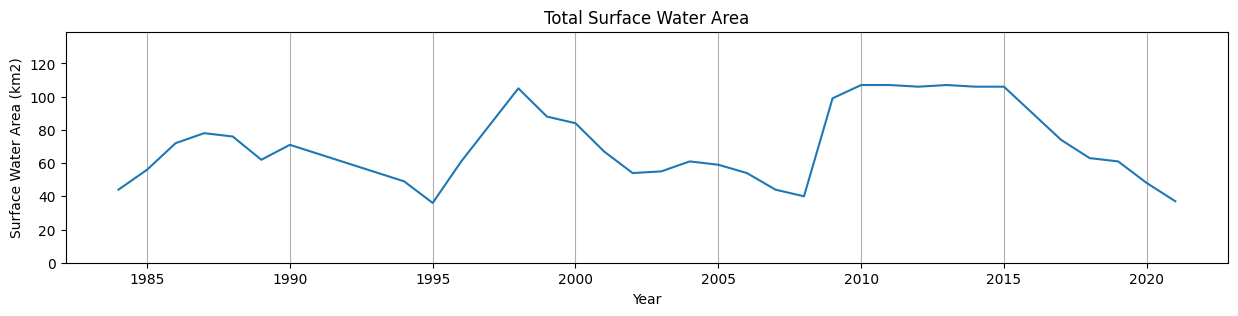

In [14]:
## plotting
fig = plot_time_series(df['year'],df['area_km2'])

In [15]:
fig.savefig('water_surface_area.png', bbox_inches='tight')


In [16]:
## Remove images with 0 area if any
image_collection = areaImages.filter(ee.Filter.gt('area_km2',0))

## Visualization parameters
visParams = {
    'bands': 'waterClass',
    'palette': ['blue']
}

## Create the image visuals
images = image_collection.map(lambda image: image.visualize(min=0, max=1, palette=['black','blue']).selfMask())

## Define GIF visualization parameters.
gifParams = {
  'region': geometry,
  'dimensions': 600,
  'framesPerSecond': 1
}

## Download the gif
url = images.getVideoThumbURL(gifParams)
subprocess.run(["wget", url, "-O", "surface_water.gif"])

CompletedProcess(args=['wget', 'https://earthengine.googleapis.com/v1/projects/monitoring-inland-water/videoThumbnails/8788c9f37f413b6008e5711269a06fe9-f76014b141036ef2f03d90b0ddf73174:getPixels', '-O', 'surface_water.gif'], returncode=0)

In [17]:
!wget https://github.com/adobe-fonts/source-sans/raw/release/TTF/SourceSans3-Black.ttf -O SourceSans3-Black.ttf


--2024-07-06 10:04:38--  https://github.com/adobe-fonts/source-sans/raw/release/TTF/SourceSans3-Black.ttf
Resolving github.com (github.com)... 140.82.113.4
Connecting to github.com (github.com)|140.82.113.4|:443... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://raw.githubusercontent.com/adobe-fonts/source-sans/release/TTF/SourceSans3-Black.ttf [following]
--2024-07-06 10:04:38--  https://raw.githubusercontent.com/adobe-fonts/source-sans/release/TTF/SourceSans3-Black.ttf
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.109.133, 185.199.110.133, 185.199.108.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.109.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 422244 (412K) [application/octet-stream]
Saving to: ‘SourceSans3-Black.ttf’

SourceSans3-Black.t 100%[===================>] 412.35K  --.-KB/s    in 0.06s   

2024-07-06 10:04:38 (6.22 MB/s) - ‘SourceSans3-Black.tt

In [18]:
def label_gif_images(gif_file, labels, font_size=30):

    '''
    Input: gif file and list of labels
    Note: List of labels must be equal to the no. of frames in the gif file

    Saves the modified gif as 'new.gif` file
    '''
    gifImage = Image.open(gif_file) ## Read the gif file
    images = [] ## List to store the modified images

    for frame, label in zip(ImageSequence.Iterator(gifImage), labels):
        frame_image = frame.copy()
        canvas = ImageDraw.Draw(frame_image)

        # Custom font style and font size
        font = ImageFont.truetype('SourceSans3-Black.ttf', font_size)

        # Add Text to an image
        w,h = gifImage.size
        txt_x, txt_y = int(0.5*w), int(0.01*h)
        canvas.text((txt_x, txt_y), f"Year: {label}", fill =(255, 0, 0), align ="center", font=font)
        images.append(frame_image)

    ## Save the gif as a new file
    images[0].save(f"new.gif", append_images=images[1:], save_all=True)

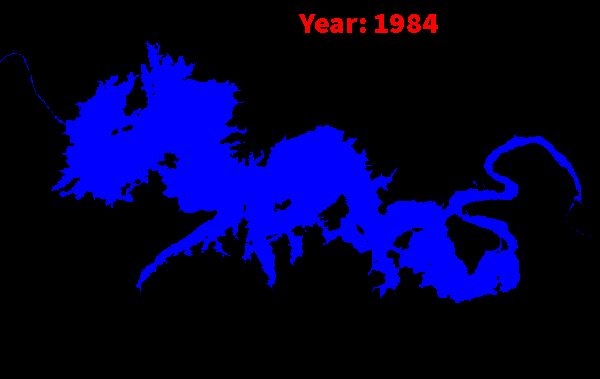

In [19]:
label_gif_images("surface_water.gif", df.year)
IpyImage("new.gif")

In [20]:
geemap.add_text_to_gif

<function geemap.timelapse.add_text_to_gif(in_gif, out_gif, xy=None, text_sequence=None, font_type='arial.ttf', font_size=20, font_color='#000000', add_progress_bar=True, progress_bar_color='white', progress_bar_height=5, duration=100, loop=0)>

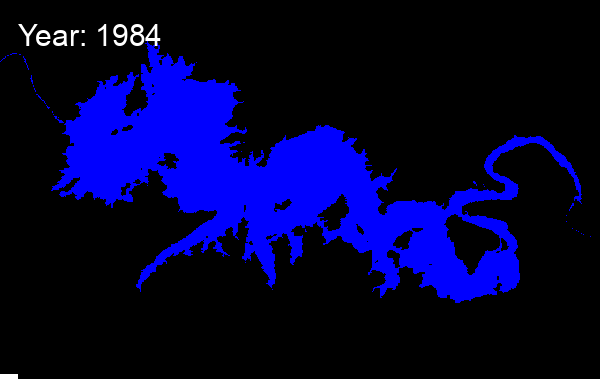

In [21]:
text_sequence=[f"Year: {year}" for year in df.year]
new_file_name = "new_surface_water.gif"

geemap.add_text_to_gif(
    "surface_water.gif",
    new_file_name,
    xy=("3%", "5%"),
    text_sequence=text_sequence,
    font_size=30,
    font_color="#ffffff",
    duration=1000
)

IpyImage(filename='new_surface_water.gif')

In [22]:
Map = geemap.Map()

vis_params = {'min': 0, 'max': 1, 'palette': ['#ece7f2','#a6bddb','#2b8cbe']}

Map.add_time_slider(areaImages.select('waterClass'), vis_params, labels=list(map(str,xs)), time_interval=1)
Map.centerObject(geometry, zoom=12)
Map

Map(center=[32.451435454255986, -7.568908953952102], controls=(WidgetControl(options=['position', 'transparent…

## Estimating the lake volume

Estimating the lake volume using the GLOBathy - Global bathymetric survey data for lakes

[Global lakes bathymetry dataset](https://gee-community-catalog.org/projects/globathy/): bathymetric data of 1.4+ million waterbodies to align with the well-established global dataset, HydroLAKES. GLOBathy uses a GIS-based framework to generate bathymetric maps based on the waterbody maximum depth estimates and HydroLAKES geometric/geophysical attributes of the waterbodies. The maximum depth estimates are validated at 1,503 waterbodies, making use of several observed data sources


In [23]:
globathy = ee.Image("projects/sat-io/open-datasets/GLOBathy/GLOBathy_bathymetry")
globathy = globathy.rename('Depth_m').unmask(0) ## Multiplying -1 to represent the data in negative
area = globathy.gt(0).multiply(ee.Image.pixelArea()).rename('area_m2')
volume = area.multiply(globathy).rename("volume_m3")

Map = geemap.Map(basemap='OpenTopoMap')
visParams = {"min": 0, "max": 30000, 'palette': ['#eff3ff','#c6dbef','#9ecae1','#6baed6','#3182bd','#08519c']}
Map.addLayer(volume.clip(geometry), visParams, 'Global Bathymetry')
Map.centerObject(geometry, zoom=12)
Map

Map(center=[32.451435454255986, -7.568908953952102], controls=(WidgetControl(options=['position', 'transparent…

### Calculate the Total Volume

Here to calculate the lake volume, I have simply multiplied the pixel area with pixel depth and calculated the total sum.

Total Volume $ = \sum_{i=1}^{n} A_i * D_i$

There could be some better way to estimate the volume from bathymetry survey but for simplicity, I have used this

In [24]:
volume = volume.select("volume_m3")
totalVolume = volume.reduceRegion(
    reducer = ee.Reducer.sum(),
    geometry = geometry,
    scale=30,
    maxPixels = 1e10
)

totalVolume = ee.Number(totalVolume.get('volume_m3')).divide(1e6).round()
## Total volume in ML
totalVolume

In [25]:
globath_depths = globathy.multiply(-1)
geemap.ee_export_image(
    globath_depths, filename="lake_terrain.tif", scale=30, region=geometry, file_per_band=False
)

Generating URL ...
Please wait ...
Data downloaded to /content/lake_terrain.tif


In [26]:
def smoothen_dataArray(tif_file, sigma = 10):
    da = rxr.open_rasterio(filename=tif_file)
    da_vals = da.isel(band=0).values ## Select the first band of the image
    # Apply gaussian filter, with sigmas as variables. Higher sigma = more smoothing and more calculations. Downside: min and max values do change due to smoothing
    sigma = [sigma, sigma] ## Sigma values in x and y direction
    z_smoothed = sp.ndimage.gaussian_filter(da_vals, sigma)

    da.data = np.expand_dims(z_smoothed, axis=0)
    return da

def plot_3D_terrain(xr_array):

    Z = xr_array.values
    Y = xr_array['y'].values
    X = xr_array['x'].values

    fig = go.Figure()

    fig.add_trace(
        go.Surface(
            z=Z,
            x=X,
            y=Y,
            colorscale = [
                # Let first 10% (0.1) of the values have color rgb(0, 0, 0)
                [0, "rgb(37, 0, 86)"],
                [0.1, "rgb(37, 0, 86)"],

                # Let values between 10-20% of the min and max of z
                # have color rgb(20, 20, 20)
                [0.1, "rgb(5, 0, 111)"],
                [0.2, "rgb(5, 0, 111)"],

                # Values between 20-30% of the min and max of z
                # have color rgb(40, 40, 40)
                [0.2, "rgb(0, 7, 129)"],
                [0.3, "rgb(0, 7, 129)"],

                [0.3, "rgb(0, 69, 172)"],
                [0.4, "rgb(0, 69, 172)"],

                [0.4, "rgb(0, 178, 192)"],
                [0.5, "rgb(0, 178, 192)"],

                [0.5, "rgb(0, 200, 182)"],
                [0.6, "rgb(0, 200, 182)"],

                [0.6, "rgb(0, 172, 115)"],
                [0.7, "rgb(0, 172, 115)"],

                [0.7, "rgb(0, 138, 56)"],
                [0.8, "rgb(0, 138, 56)"],

                [0.8, "rgb(0, 103, 12)"],
                [0.9, "rgb(0, 103, 12)"],

                [0.9, "rgb(18, 74, 0)"],
                [1.0, "rgb(18, 74, 0)"]
            ],
            hovertemplate ='<b>Depth</b>: %{z:.2f} m',
            name=""
        )
    )

    camera = dict(
        up=dict(x=0, y=0, z=1),
        eye=dict(x=1, y=1, z=1)
    )

    fig.update_layout(
        margin=dict(l=0, r=0, t=30, b=0),
        title = f"Lake Topography | Total Estimated Volume: {totalVolume.getInfo()} ML"
    )

    fig.update_xaxes(showticklabels=False, title='')
    fig.update_yaxes(showticklabels=False, title='')

    # Set the box aspect ratio (equal scales for all axes)
    fig.update_scenes(aspectratio=dict(x=5, y=5,z=1))

    return fig

In [27]:
ds = smoothen_dataArray('lake_terrain.tif', sigma=5)
da = ds.isel(band=0)
fig = plot_3D_terrain(da)
fig.show()

## References

1. [Calculating area in google earth engine](https://spatialthoughts.com/2020/06/19/calculating-area-gee/)
2. [Module2: Calculating the surface water mapping](https://courses.spatialthoughts.com/gee-water-resources-management.html#module-2-surface-water-mapping)
3. Khazaei, Bahram; Read, Laura K; Casali, Matthew; Sampson, Kevin M; Yates, David N (2022): GLOBathy Bathymetry Rasters. figshare.
Dataset. https://doi.org/10.6084/m9.figshare.13404635.v1
4. [colorscales in plotly](https://plotly.com/python/builtin-colorscales/)
5. [Constructing custom colorscale on plotly](https://plotly.com/python/colorscales/#constructing-a-discrete-or-discontinuous-color-scale)